In [1]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install scipy
!pip install harmonica

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.6/186.6 kB 11.3 MB/s eta 0:00:00


Loading synthetic_geophysical_data_SHALLOW_MODEL.csv...
Performing 'blind' Bouguer correction...
Filtering radiometric data...
Data preparation complete. Ready for Joint Inversion.
Starting Joint Differential Evolution for 11 parameters (Constrained Top, Weighted Misfit)...
This will take several minutes.
differential_evolution step 1: f(x)= 131.12089239758197
differential_evolution step 2: f(x)= 126.0044795251482
differential_evolution step 3: f(x)= 120.7726755915501
differential_evolution step 4: f(x)= 120.7726755915501
differential_evolution step 5: f(x)= 119.06252452033405
differential_evolution step 6: f(x)= 118.37230548338138
differential_evolution step 7: f(x)= 118.37230548338138
differential_evolution step 8: f(x)= 118.37230548338138
differential_evolution step 9: f(x)= 118.37230548338138
differential_evolution step 10: f(x)= 118.33607339772927
differential_evolution step 11: f(x)= 116.70184026543194
differential_evolution step 12: f(x)= 116.70184026543194
differential_evolutio

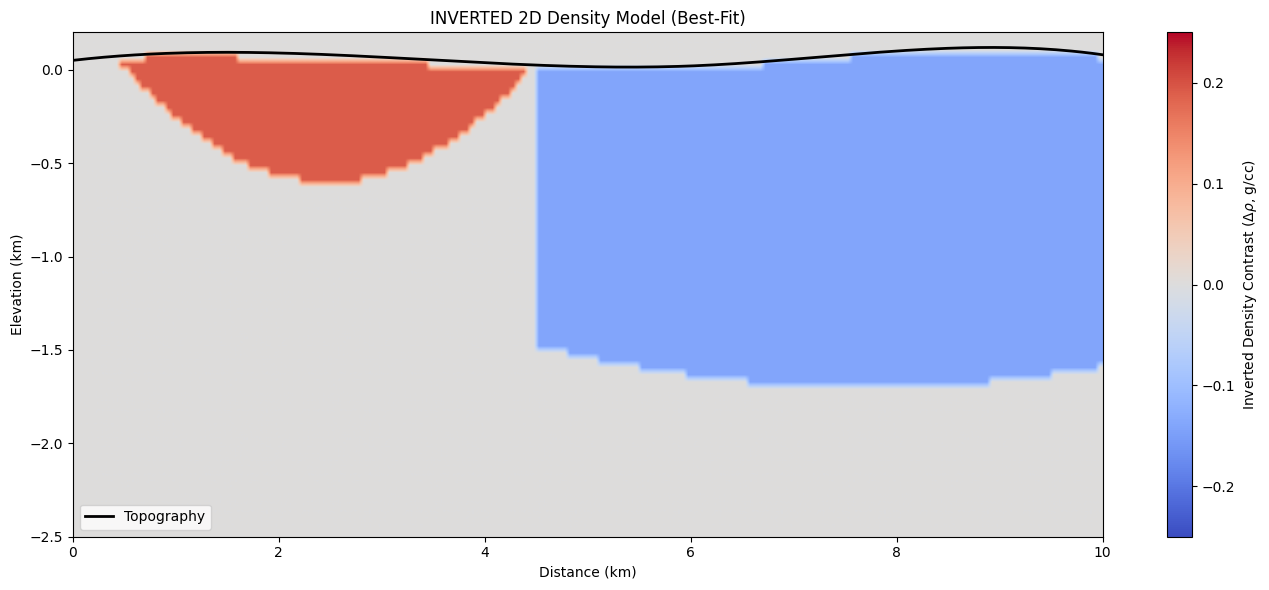


Plotting data fits...


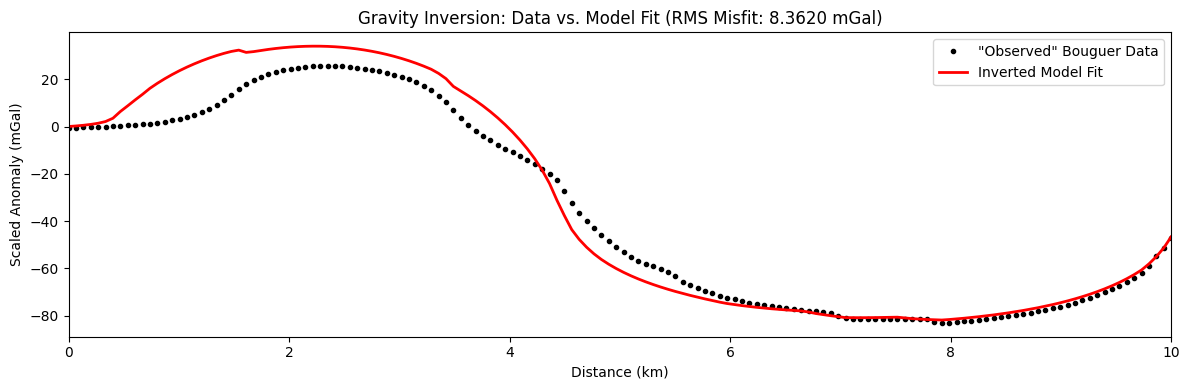

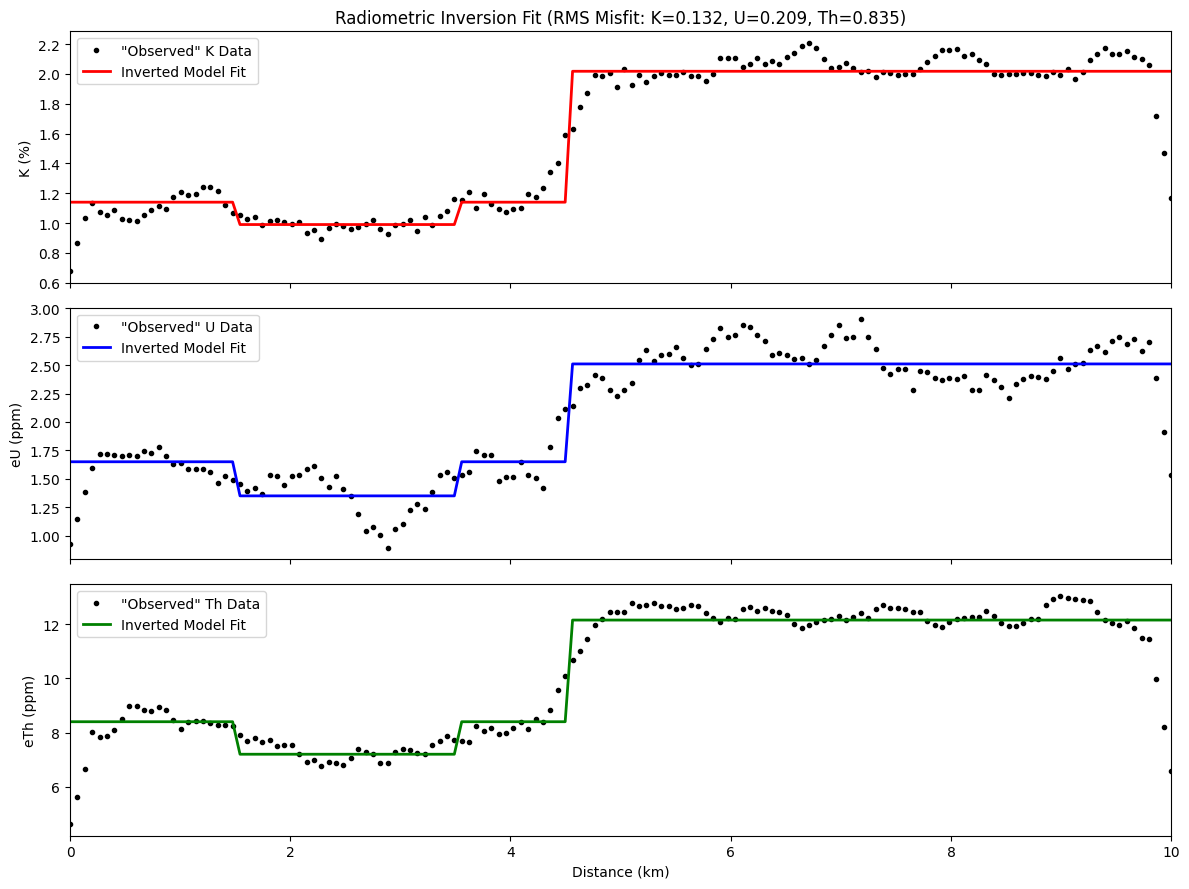

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import harmonica as hm
from scipy.optimize import differential_evolution
import time
import warnings

# -------------------------------------------------------------------
# 1. LOAD AND PREPARE DATA FOR INVERSION
# -------------------------------------------------------------------

print("Loading synthetic_geophysical_data_SHALLOW_MODEL.csv...")
try:
    df = pd.read_csv('/kaggle/input/new-dataset-shallow-model/synthetic_geophysical_data_SHALLOW_MODEL.csv')
except FileNotFoundError:
    print("FATAL ERROR: 'synthetic_geophysical_data_SHALLOW_MODEL.csv' not found.")
    print(">>> PLEASE RUN THE FORWARD MODELING SCRIPT FIRST TO GENERATE THIS FILE. <<<")
    # Create dummy data to allow script to run without crashing
    df = pd.DataFrame(np.random.rand(150, 6), 
                      columns=['Distance_m', 'Elevation_m', 'Raw_Gravity_mGal', 
                               'Raw_K_percent', 'Raw_eU_ppm', 'Raw_eTh_ppm'])

# --- Observation Coordinates ---
OBS_X = df['Distance_m'].values
OBS_Z_ground = df['Elevation_m'].values
OBS_Z_sensor = OBS_Z_ground + 5.0
OBS_Y = np.zeros_like(OBS_X)
coordinates = (OBS_X, OBS_Y, OBS_Z_sensor)
Raw_Gravity_mGal = df['Raw_Gravity_mGal'].values

# --- A Priori Model Space & Topography ---
X_MIN, X_MAX = 0, 10000
Z_MIN, Z_MAX = -2500, 200
Y_EXTENT = 20000
NX, NZ = 200, 70
X_COORDS = np.linspace(X_MIN, X_MAX, NX)
Z_COORDS = np.linspace(Z_MIN, Z_MAX, NZ)
XX, ZZ = np.meshgrid(X_COORDS, Z_COORDS)

# Create topography function from the data
f_topo = interp1d(
    df['Distance_m'], 
    df['Elevation_m'], 
    kind='cubic', 
    fill_value="extrapolate"
)

# --- A Priori Correction Assumptions ---
RHO_REF_G_CC = 2.67
RHO_HOST_G_CC = 2.67
RHO_AIR_G_CC = 0.0
RHO_SOIL_G_CC = 2.20
SOIL_THICKNESS = 10.0

# --- A Priori Radiometric Properties (Known) ---
RAD_BG = {'K': 1.0, 'U': 2.0, 'Th': 7.0}
RAD_DENSE = {'K': 0.5, 'U': 1.0, 'Th': 3.0}
RAD_SOIL = {'K': 1.2, 'U': 1.5, 'Th': 9.0}
MIX_RATIO = 0.7

# --- Build 2.5D Prisms for Calculations ---
DX = X_COORDS[1] - X_COORDS[0]
DZ = Z_COORDS[1] - Z_COORDS[0]
X_EDGES = np.linspace(X_MIN - DX/2, X_MAX + DX/2, NX + 1)
Z_EDGES = np.linspace(Z_MIN - DZ/2, Z_MAX + DZ/2, NZ + 1)
XX_EDGES, ZZ_EDGES = np.meshgrid(X_EDGES[:-1], Z_EDGES[:-1])
west = XX_EDGES.ravel()
east = (XX_EDGES + DX).ravel()
south = np.full_like(west, -Y_EXTENT / 2)
north = np.full_like(west, Y_EXTENT / 2)
bottom = ZZ_EDGES.ravel()
top = (ZZ_EDGES + DZ).ravel()
prisms = np.vstack([west, east, south, north, bottom, top]).T

# -------------------------------------------------------------------
# 2. "BLIND" DATA PROCESSING
# -------------------------------------------------------------------
print("Performing 'blind' Bouguer correction...")
density_model_topo_only = np.full_like(XX, (RHO_HOST_G_CC - RHO_REF_G_CC), dtype=float)
soil_mask_for_topo = (ZZ > (f_topo(XX) - SOIL_THICKNESS)) & (ZZ <= f_topo(XX))
air_mask = (ZZ > f_topo(XX))
density_model_topo_only[soil_mask_for_topo] = (RHO_SOIL_G_CC - RHO_REF_G_CC)
density_model_topo_only[air_mask] = (RHO_AIR_G_CC - RHO_REF_G_CC)
density_model_topo_only_kg_m3 = density_model_topo_only.ravel() * 1000
gravity_topo_effect = hm.prism_gravity(
    coordinates, prisms, density_model_topo_only_kg_m3, field="g_z"
)
gravity_topo_effect_mgal = gravity_topo_effect * 1e5
bouguer_anomaly_mgal = Raw_Gravity_mGal - gravity_topo_effect_mgal

# --- DATASET 1: Gravity Data to Invert ---
data_to_invert_g = bouguer_anomaly_mgal / 10000.0 # Apply scaling
var_g = np.var(data_to_invert_g)

print("Filtering radiometric data...")
FILTER_WINDOW_SIZE = 7
smoothing_window = np.ones(FILTER_WINDOW_SIZE) / FILTER_WINDOW_SIZE

# --- DATASETS 2, 3, 4: Radiometric Data to Invert ---
data_to_invert_k = np.convolve(df['Raw_K_percent'].values, smoothing_window, mode='same')
data_to_invert_u = np.convolve(df['Raw_eU_ppm'].values, smoothing_window, mode='same')
data_to_invert_th = np.convolve(df['Raw_eTh_ppm'].values, smoothing_window, mode='same')
var_k = np.var(data_to_invert_k)
var_u = np.var(data_to_invert_u)
var_th = np.var(data_to_invert_th)

print("Data preparation complete. Ready for Joint Inversion.")

# -------------------------------------------------------------------
# 3. DEFINE THE JOINT INVERSION ENGINE
# -------------------------------------------------------------------

# --- A Priori (Fixed) Geometric Node X-Locations ---
DENSE_TOP_X_NODES = [1500, 2500, 3500]
DENSE_BOT_X_NODES = [1500, 2500, 3500]
BASIN_BOT_X_NODES = [4500, 7000, 10000]
FAULT_X_LOC = 4500
DENSE_BODY_X_MASK_1D = (OBS_X >= 1500) & (OBS_X < 3500)
BASIN_X_MASK_1D = (OBS_X >= FAULT_X_LOC)
BASIN_X_MASK_2D = (XX > FAULT_X_LOC)

# --- A Priori (Fixed) Dense Body Top Z-Locations ---
# This is our strongest "a priori" constraint from the radiometric map
# We assume the body is *just* below the 10m soil layer
DENSE_TOP_Z_NODES_FIXED = [
    f_topo(1500) - SOIL_THICKNESS,
    f_topo(2500) - SOIL_THICKNESS,
    f_topo(3500) - SOIL_THICKNESS
] 
f_dense_top_FIXED = interp1d(
    DENSE_TOP_X_NODES, DENSE_TOP_Z_NODES_FIXED, 
    kind='quadratic', fill_value="extrapolate"
)
DENSE_BODY_TOP_Z_FIXED = f_dense_top_FIXED(XX)


def run_joint_forward_model(params):
    """
    Takes 11 parameters, builds the full 2D model, and returns
    four data curves: (gravity, K, U, Th).
    """
    # Unpack the 11 parameters
    (dense_rho, basin_rho, 
     basin_K, basin_U, basin_Th,
     d_bot_z1, d_bot_z2, d_bot_z3,
     b_bot_z1, b_bot_z2, b_bot_z3) = params
    
    # === 1. Build Gravity Model ===
    
    # --- Dense Body Bottom (INVERTED) ---
    dense_bot_z_nodes = [d_bot_z1, d_bot_z2, d_bot_z3]
    f_dense_bot = interp1d(DENSE_BOT_X_NODES, dense_bot_z_nodes,
                           kind='quadratic', fill_value="extrapolate")
    # --- Basin Bottom (INVERTED) ---
    basin_bot_z_nodes = [b_bot_z1, b_bot_z2, b_bot_z3]
    f_basin_bot = interp1d(BASIN_BOT_X_NODES, basin_bot_z_nodes,
                           kind='quadratic', fill_value="extrapolate")

    model_grid = np.zeros_like(XX)
    # Use the FIXED top surface for the mask
    dense_mask = (ZZ < DENSE_BODY_TOP_Z_FIXED) & (ZZ >= f_dense_bot(XX))
    basin_mask = BASIN_X_MASK_2D & (ZZ < f_topo(XX)) & (ZZ >= f_basin_bot(XX))
    
    model_grid[dense_mask] = dense_rho
    model_grid[basin_mask] = basin_rho
    
    g_z = hm.prism_gravity(
        coordinates, prisms, model_grid.ravel() * 1000, field="g_z"
    )
    gravity_guess = g_z * 1e5 / 10000.0
    
    # === 2. Build Radiometric Model ===
    
    bedrock_geology = np.ones_like(OBS_X, dtype=int) # 1 = Host
    bedrock_geology[DENSE_BODY_X_MASK_1D] = 2 # 2 = Dense
    bedrock_geology[BASIN_X_MASK_1D] = 3      # 3 = Basin

    K_bedrock = np.zeros_like(OBS_X)
    U_bedrock = np.zeros_like(OBS_X)
    Th_bedrock = np.zeros_like(OBS_X)

    mask_1 = (bedrock_geology == 1); K_bedrock[mask_1] = RAD_BG['K']; U_bedrock[mask_1] = RAD_BG['U']; Th_bedrock[mask_1] = RAD_BG['Th']
    mask_2 = (bedrock_geology == 2); K_bedrock[mask_2] = RAD_DENSE['K']; U_bedrock[mask_2] = RAD_DENSE['U']; Th_bedrock[mask_2] = RAD_DENSE['Th']
    mask_3 = (bedrock_geology == 3); K_bedrock[mask_3] = basin_K; U_bedrock[mask_3] = basin_U; Th_bedrock[mask_3] = basin_Th
    
    mix_ratio = np.full_like(OBS_X, MIX_RATIO); mix_ratio[mask_2] = MIX_RATIO # Soil is continuous
    
    k_guess = (K_bedrock * (1 - mix_ratio)) + (RAD_SOIL['K'] * mix_ratio)
    u_guess = (U_bedrock * (1 - mix_ratio)) + (RAD_SOIL['U'] * mix_ratio)
    th_guess = (Th_bedrock * (1 - mix_ratio)) + (RAD_SOIL['Th'] * mix_ratio)

    return gravity_guess, k_guess, u_guess, th_guess

def calculate_misfit(params, *args):
    """
    The objective function to be minimized.
    Calculates the *joint* normalized misfit.
    """
    # Unpack the fixed data and variances
    data_g, data_k, data_u, data_th, var_g, var_k, var_u, var_th = args
    
    try:
        # Run the joint forward model
        g_guess, k_guess, u_guess, th_guess = run_joint_forward_model(params)
        
        # Calculate normalized misfit for each dataset
        misfit_g = np.sum((g_guess - data_g)**2) / var_g
        misfit_k = np.sum((k_guess - data_k)**2) / var_k
        misfit_u = np.sum((u_guess - data_u)**2) / var_u
        misfit_th = np.sum((th_guess - data_th)**2) / var_th
        
        # --- KEY CHANGE: RE-WEIGHTING THE MISFIT ---
        # We now heavily penalize a bad gravity fit to force the
        # optimizer to solve the density-depth ambiguity.
        total_misfit = (10.0 * misfit_g) + misfit_k + misfit_u + misfit_th
        
        return total_misfit
    
    except Exception as e:
        # Penalize bad/impossible geometries
        return 1e99 

# -------------------------------------------------------------------
# 4. RUN THE DIFFERENTIAL EVOLUTION INVERSION
# -------------------------------------------------------------------

# --- Define Parameter Bounds (11 parameters) ---
# --- KEY CHANGE: Tighter bounds on density ---
param_bounds = [
    # Physical Properties (5)
    (0.19, 0.21),   # 1. dense_rho (True: 0.20) - TIGHT PRIOR
    (-0.16, -0.14), # 2. basin_rho (True: -0.15) - TIGHT PRIOR
    (3.5, 4.5),     # 3. basin_K (True: 4.0)
    (4.5, 5.5),     # 4. basin_U (True: 5.0)
    (19.0, 21.0),   # 5. basin_Th (True: 20.0)
    # Dense Bot Z (3)
    (-550, -450),   # 6. d_bot_z1 (True: -500)
    (-600, -500),   # 7. d_bot_z2 (True: -550)
    (-530, -430),   # 8. d_bot_z3 (True: -480)
    # Basin Bot Z (3)
    (-1500, -1300), # 9. b_bot_z1 (True: -1400)
    (-1700, -1500), # 10. b_bot_z2 (True: -1600)
    (-1600, -1400)  # 11. b_bot_z3 (True: -1500)
]

# True parameters (for final comparison)
true_params = [
    0.20, -0.15, 4.0, 5.0, 20.0,
    -500, -550, -480, 
    -1400, -1600, -1500
]
param_names = [
    'Dense Rho', 'Basin Rho', 'Basin K', 'Basin U', 'Basin Th',
    'd_bot_z1', 'd_bot_z2', 'd_bot_z3', 
    'b_bot_z1', 'b_bot_z2', 'b_bot_z3'
]

# --- Pack the args for the misfit function ---
inversion_args = (
    data_to_invert_g, data_to_invert_k, data_to_invert_u, data_to_invert_th,
    var_g, var_k, var_u, var_th
)

print(f"Starting Joint Differential Evolution for 11 parameters (Constrained Top, Weighted Misfit)...")
print("This will take several minutes.")
start_time = time.time()

# --- Run the Optimizer ---
with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning) # Ignore overflow warnings
    result = differential_evolution(
        calculate_misfit,
        bounds=param_bounds,
        args=inversion_args, 
        strategy='best1bin',
        maxiter=200,      
        popsize=20,       
        tol=0.01,
        mutation=(0.5, 1),
        recombination=0.7,
        disp=True,        # Print progress
        workers=1,        # Use single core to prevent fork error
        updating='immediate'
    )

print(f"\nOptimization complete in {time.time() - start_time:.2f} seconds.")

# -------------------------------------------------------------------
# 5. PLOT AND DISPLAY RESULTS
# -------------------------------------------------------------------

inverted_params = result.x
final_joint_misfit = result.fun

# --- 1. Print Parameter Comparison ---
print("\n--- JOINT INVERSION RESULTS (CONSTRAINED) ---")
print(f"Final Joint Misfit: {final_joint_misfit:.4f}")
print("\n--- Inverted Parameters ---")
print("Parameter     | Inverted Value | True Value")
print("-------------------------------------------------")
for i in range(len(inverted_params)):
    print(f"{param_names[i]:<13} | {inverted_params[i]:>14.2f} | {true_params[i]:>10.2f}")

# --- 2. Build and Plot Inverted 2D Model ---
print("\nPlotting inverted 2D model...")
# Build the 2D model grid using the *best-fit* parameters
(dense_rho, basin_rho, 
 basin_K, basin_U, basin_Th,
 d_bot_z1, d_bot_z2, d_bot_z3,
 b_bot_z1, b_bot_z2, b_bot_z3) = inverted_params

# Re-create the model geometry using the inverted parameters
dense_bot_z_nodes = [d_bot_z1, d_bot_z2, d_bot_z3]
f_dense_bot = interp1d(DENSE_BOT_X_NODES, dense_bot_z_nodes,
                       kind='quadratic', fill_value="extrapolate")
basin_bot_z_nodes = [b_bot_z1, b_bot_z2, b_bot_z3]
f_basin_bot = interp1d(BASIN_BOT_X_NODES, basin_bot_z_nodes,
                       kind='quadratic', fill_value="extrapolate")

inverted_model_grid = np.zeros_like(XX)
# Use the FIXED top surface for the mask
dense_mask = (ZZ < DENSE_BODY_TOP_Z_FIXED) & (ZZ >= f_dense_bot(XX))
basin_mask = (BASIN_X_MASK_2D) & (ZZ < f_topo(XX)) & (ZZ >= f_basin_bot(XX))
inverted_model_grid[dense_mask] = dense_rho
inverted_model_grid[basin_mask] = basin_rho

fig, ax = plt.subplots(figsize=(13.8, 6))
im = ax.imshow(
    inverted_model_grid,
    extent=[X_MIN / 1000, X_MAX / 1000, Z_MIN / 1000, Z_MAX / 1000],
    origin='lower', aspect='auto', cmap='coolwarm',
    interpolation='bilinear', # Use bilinear for smooth edges
    vmin=-0.25, vmax=0.25
)
ax.plot(X_COORDS / 1000, f_topo(X_COORDS) / 1000, 'k-', lw=2, label='Topography')
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Inverted Density Contrast ($\Delta\\rho$, g/cc)')
ax.set_ylabel('Elevation (km)')
ax.set_xlabel('Distance (km)')
ax.set_title(f'INVERTED 2D Density Model (Best-Fit)')
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()

# --- 3. Plot Data Fits ---
print("\nPlotting data fits...")
g_fit, k_fit, u_fit, th_fit = run_joint_forward_model(inverted_params)
rms_misfit_g = np.sqrt(np.mean((g_fit - data_to_invert_g)**2))
rms_misfit_k = np.sqrt(np.mean((k_fit - data_to_invert_k)**2))
rms_misfit_u = np.sqrt(np.mean((u_fit - data_to_invert_u)**2))
rms_misfit_th = np.sqrt(np.mean((th_fit - data_to_invert_th)**2))

# --- Plot Gravity Fit ---
fig_g, ax_g = plt.subplots(figsize=(12, 4))
ax_g.plot(OBS_X / 1000, data_to_invert_g, 'ko', markersize=3, label='"Observed" Bouguer Data')
ax_g.plot(OBS_X / 1000, g_fit, 'r-', lw=2, label='Inverted Model Fit')
ax_g.set_xlabel('Distance (km)')
ax_g.set_ylabel('Scaled Anomaly (mGal)')
ax_g.set_title(f'Gravity Inversion: Data vs. Model Fit (RMS Misfit: {rms_misfit_g:.4f} mGal)')
ax_g.legend()
ax_g.set_xlim(X_MIN / 1000, X_MAX / 1000)
plt.tight_layout()
plt.show()

# --- Plot Radiometric Fits ---
fig_rad, (ax_k, ax_u, ax_th) = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# K plot
ax_k.plot(OBS_X / 1000, data_to_invert_k, 'ko', markersize=3, label='"Observed" K Data')
ax_k.plot(OBS_X / 1000, k_fit, 'r-', lw=2, label='Inverted Model Fit')
ax_k.set_ylabel('K (%)')
ax_k.set_title(f'Radiometric Inversion Fit (RMS Misfit: K={rms_misfit_k:.3f}, U={rms_misfit_u:.3f}, Th={rms_misfit_th:.3f})')
ax_k.legend()

# U plot
ax_u.plot(OBS_X / 1000, data_to_invert_u, 'ko', markersize=3, label='"Observed" U Data')
ax_u.plot(OBS_X / 1000, u_fit, 'b-', lw=2, label='Inverted Model Fit')
ax_u.set_ylabel('eU (ppm)')
ax_u.legend()

# Th plot
ax_th.plot(OBS_X / 1000, data_to_invert_th, 'ko', markersize=3, label='"Observed" Th Data')
ax_th.plot(OBS_X / 1000, th_fit, 'g-', lw=2, label='Inverted Model Fit')
ax_th.set_ylabel('eTh (ppm)')
ax_th.set_xlabel('Distance (km)')
ax_th.set_xlim(X_MIN / 1000, X_MAX / 1000)
ax_th.legend()

plt.tight_layout()
plt.show()